In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

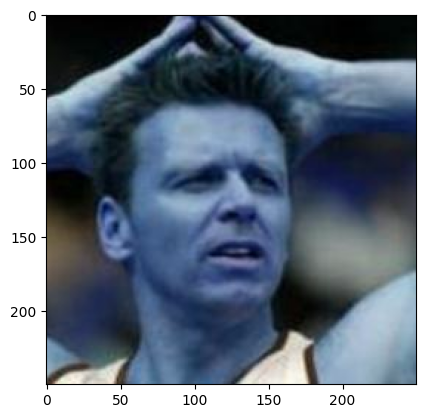

In [10]:
img = np.zeros((120, 120), dtype=np.uint8)
img = cv2.imread('./LFW-FER/eval/negative/Steve_Backley_0002.jpg')
plt.imshow(img)
plt.show()


- plt.imshow()함수는 RGB 순으로 해석, OpenCV는 컬러 이미지를 BGR순으로 인식 하므로 컬러를 뒤집어서 나타내 주어야함

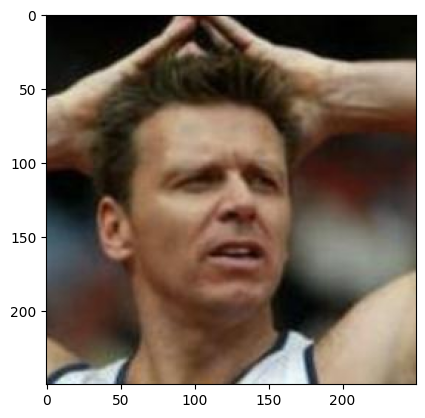

In [17]:
plt.imshow(img[:,:,::-1])